In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 34.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
# Path to annotation file
annotations_path = '/content/train.SI5.corpus.csv'

# Load annotations into a DataFrame
annotations_df = pd.read_csv(annotations_path, sep='|')
annotations_df

,id,folder,signer,annotation
0,01April_2010_Thursday_heute_default-0,01April_2010_Thursday_heute_default-0/1/*.png,Signer04,__ON__ LIEB ZUSCHAUER ABEND WINTER GESTERN loc...
1,01April_2010_Thursday_heute_default-2,01April_2010_Thursday_heute_default-2/1/*.png,Signer04,loc-WEST WARM loc-WEST BLEIBEN KUEHL
2,01April_2010_Thursday_heute_default-3,01April_2010_Thursday_heute_default-3/1/*.png,Signer04,KUEHL KUEHL IN-KOMMEND NACHT MINUS loc-MINUS-P...
3,01April_2010_Thursday_heute_default-4,01April_2010_Thursday_heute_default-4/1/*.png,Signer04,MORGEN TEMPERATUR ACHT BIS DREIZEHN MAXIMAL DR...
4,01April_2010_Thursday_heute_default-6,01April_2010_Thursday_heute_default-6/1/*.png,Signer04,AUCH SAMSTAG WEST FREUNDLICH IX TROCKEN WEST R...
...,...,...,...,...
4371,31October_2009_Saturday_tagesschau_default-4,31October_2009_Saturday_tagesschau_default-4/1...,Signer03,__ON__ NORD loc-REGION HEUTE NACHT SCHON WOLKE...
4372,31October_2009_Saturday_tagesschau_default-6,31October_2009_Saturday_tagesschau_default-6/1...,Signer03,__ON__ AUCH STURM WEHEN WEHEN NORD SEE STURM l...
4373,31October_2009_Saturday_tagesschau_default-10,31October_2009_Saturday_tagesschau_default-10/...,Signer03,__ON__ MORGEN loc-SECHS GRAD loc-SIEBENZEHN GR...
4374,31October_2009_Saturday_tagesschau_default-11,31October_2009_Saturday_tagesschau_default-11/...,Signer03,__ON__ MONTAG loc-SUEDOST loc-REGION VIEL REGE...


In [ ]:
import os
import cv2
from tqdm import tqdm
from multiprocessing import Pool, cpu_count


def merge_single_file(args):
    base_name, paths, output_folder, input_folder = args
    left_hand_path = paths.get("left")
    right_hand_path = paths.get("right")

    # Skip if either file is missing
    if not left_hand_path or not right_hand_path:
        return

    # Construct output path
    try:
        output_path = os.path.join(
            output_folder,
            os.path.relpath(left_hand_path, input_folder).replace("_left_hand0.png", "_merged.png")
        )
    except ValueError as e:
        print(f"Error calculating relative path for {left_hand_path}: {e}")
        return

    # Read both images
    left_hand_img = cv2.imread(left_hand_path, cv2.IMREAD_COLOR)
    right_hand_img = cv2.imread(right_hand_path, cv2.IMREAD_COLOR)

    if left_hand_img is None or right_hand_img is None:
        print(f"Error loading images: {left_hand_path} or {right_hand_path}")
        return

    # Match heights (resize smaller image to match larger image's height)
    target_height = max(left_hand_img.shape[0], right_hand_img.shape[0])
    left_hand_img = cv2.resize(left_hand_img, (left_hand_img.shape[1], target_height))
    right_hand_img = cv2.resize(right_hand_img, (right_hand_img.shape[1], target_height))

    # Merge horizontally
    merged_img = cv2.hconcat([left_hand_img, right_hand_img])

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the merged image
    cv2.imwrite(output_path, merged_img)


def merge_left_right_hands(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # Traverse the directory to find valid pairs
    file_groups = {}
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith("_left_hand0.png"):
                base_name = file.replace("_left_hand0.png", "")
                left_path = os.path.join(root, file)
                if base_name not in file_groups:
                    file_groups[base_name] = {}
                file_groups[base_name]["left"] = left_path
            elif file.endswith("_right_hand0.png"):
                base_name = file.replace("_right_hand0.png", "")
                right_path = os.path.join(root, file)
                if base_name not in file_groups:
                    file_groups[base_name] = {}
                file_groups[base_name]["right"] = right_path

    # Prepare for multiprocessing
    args_list = [
        (base_name, paths, output_folder, input_folder) for base_name, paths in file_groups.items()
    ]

    # Use multiprocessing with progress tracking
    with Pool(cpu_count()) as pool:
        list(tqdm(pool.imap(merge_single_file, args_list), total=len(args_list), desc="Merging Frames"))


def main():
    input_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train'  # Update with your input folder path
    output_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged'  # Update with your output folder path

    print("Starting merging of left and right hand frames...")
    merge_left_right_hands(input_folder, output_folder)
    print(f"Merging completed! Merged frames saved in: {output_folder}")


if __name__ == "__main__":
    main()


Starting merging of left and right hand frames...


Merging Frames: 100%|██████████| 24522/24522 [37:55<00:00, 10.78it/s]

Merging completed! Merged frames saved in: /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged


In [27]:
from tqdm import tqdm
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
import numpy as np


# Load a multilingual SBERT model that includes German
model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

# Create the directory for saving embeddings if it doesn't exist
output_dir = "/content/drive/MyDrive/Phoenix-2014/Sign Language Detection Anshuman Rath/Vector_annotations"
os.makedirs(output_dir, exist_ok=True)

# Vectorize annotations and save embeddings with progress bar
for index, row in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Embedding Annotations"):
    annotation_id = row['id']
    annotation_text = row['annotation']

    # Compute embedding for the annotation
    embedding = model.encode(annotation_text)

    # Define the output file path
    output_file = os.path.join(output_dir, f"{annotation_id}.npy")

    # Save the embedding as a .npy file
    with open(output_file, "wb") as f:
        np.save(f, embedding)

print("All embeddings have been saved.")


Embedding Annotations: 100%|██████████| 4376/4376 [01:03<00:00, 68.95it/s]

All embeddings have been saved.


In [ ]:
import os
import cv2
from tqdm import tqdm
from shutil import copy2
from multiprocessing import Pool, cpu_count


def merge_images(left_path, right_path, output_path):
    # Read images
    left_img = cv2.imread(left_path, cv2.IMREAD_COLOR)
    right_img = cv2.imread(right_path, cv2.IMREAD_COLOR)

    if left_img is None or right_img is None:
        print(f"Error loading images: {left_path} or {right_path}")
        return

    # Match heights
    target_height = max(left_img.shape[0], right_img.shape[0])
    left_img = cv2.resize(left_img, (left_img.shape[1], target_height))
    right_img = cv2.resize(right_img, (right_img.shape[1], target_height))

    # Merge horizontally
    merged_img = cv2.hconcat([left_img, right_img])

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save merged image
    cv2.imwrite(output_path, merged_img)


def process_file(args):
    """Handle a single file: either merge or copy."""
    base_name, paths, output_folder, input_folder = args
    left_path = paths.get("left")
    right_path = paths.get("right")

    if left_path and right_path:
        # Merge left and right images
        output_path = os.path.join(
            output_folder,
            os.path.relpath(left_path, input_folder).replace("_left_hand0.png", "_merged.png"),
        )
        merge_images(left_path, right_path, output_path)
    else:
        # Copy any other image
        for path in paths.values():
            output_path = os.path.join(output_folder, os.path.relpath(path, input_folder))
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            copy2(path, output_path)


def collect_files(input_folder):
    """Scan the input folder and group files for merging or copying."""
    file_groups = {}
    for root, _, files in os.walk(input_folder):
        for file in files:
            file_path = os.path.join(root, file)

            if "_left_hand0.png" in file:
                base_name = file.replace("_left_hand0.png", "")
                file_groups.setdefault(base_name, {})["left"] = file_path
            elif "_right_hand0.png" in file:
                base_name = file.replace("_right_hand0.png", "")
                file_groups.setdefault(base_name, {})["right"] = file_path
            else:
                # Any other file
                file_groups.setdefault(file, {"unlabeled": file_path})
    return file_groups


def process_directory(input_folder, output_folder):
    """Process files: merge left/right pairs and copy the rest."""
    os.makedirs(output_folder, exist_ok=True)

    # Collect files to process
    file_groups = collect_files(input_folder)

    # Prepare multiprocessing arguments
    args_list = [
        (base_name, paths, output_folder, input_folder)
        for base_name, paths in file_groups.items()
    ]

    # Process with multiprocessing
    with Pool(cpu_count()) as pool:
        list(tqdm(pool.imap(process_file, args_list), total=len(args_list), desc="Processing Files"))


def check_new_and_process(input_folder, output_folder):
    """Compare input and output directories and process only new files."""
    input_files = set()
    output_files = set()

    # Collect all relative file paths in input folder
    for root, _, files in os.walk(input_folder):
        for file in files:
            input_files.add(os.path.relpath(os.path.join(root, file), input_folder))

    # Collect all relative file paths in output folder
    for root, _, files in os.walk(output_folder):
        for file in files:
            output_files.add(os.path.relpath(os.path.join(root, file), output_folder))

    # Identify new files
    new_files = input_files - output_files
    if not new_files:
        print("No new files detected. Skipping processing.")
        return

    print(f"Found {len(new_files)} new files. Processing...")
    process_directory(input_folder, output_folder)


def main():
    input_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train'  # Update path
    output_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged'  # Update path

    print("Checking for new files...")
    check_new_and_process(input_folder, output_folder)
    print("Processing completed!")


if __name__ == "__main__":
    main()


Checking for new files...
Found 184146 new files. Processing...


Processing Files: 100%|██████████| 65777/65777 [13:51<00:00, 79.07it/s]


Processing completed!


In [ ]:
import os
import hashlib
import pandas as pd
from tqdm import tqdm


def calculate_file_hash(file_path):
    """Calculate the SHA-256 hash of a file for duplicate detection."""
    hash_sha256 = hashlib.sha256()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_sha256.update(chunk)
    return hash_sha256.hexdigest()


def clean_directory(cropped_merged_folder, annotations_df):
    # Map to keep track of hashes for duplicate detection
    file_hash_map = {}
    duplicates_to_remove = []

    # Collect all merged PNGs
    merged_files = set()
    for root, _, files in os.walk(cropped_merged_folder):
        for file in files:
            if file.endswith("_merged.png"):
                base_name = file.replace("_merged.png", "")
                merged_files.add(base_name)

    # Traverse files and clean unnecessary ones
    for root, _, files in os.walk(cropped_merged_folder):
        for file in files:
            file_path = os.path.join(root, file)
            base_name = None

            # Identify base name for *_left_hand0.png and *_right_hand0.png
            if file.endswith("_left_hand0.png") or file.endswith("_right_hand0.png"):
                base_name = file.replace("_left_hand0.png", "").replace("_right_hand0.png", "")

            # If a merged version exists for the base name, delete this file
            if base_name and base_name in merged_files:
                print(f"Deleting {file_path} (merged version exists)")
                os.remove(file_path)
                continue

            # Check for duplicates using hashes
            file_hash = calculate_file_hash(file_path)
            if file_hash in file_hash_map:
                duplicates_to_remove.append(file_path)
                print(f"Duplicate detected: {file_path} (same as {file_hash_map[file_hash]})")
            else:
                file_hash_map[file_hash] = file_path

    # Remove duplicates
    for duplicate in duplicates_to_remove:
        os.remove(duplicate)
        print(f"Removed duplicate: {duplicate}")

    print(f"Cleaning completed. Remaining files: {len(file_hash_map)}")


def main():

    # Cropped merged folder path
    cropped_merged_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged'  # Update path

    print("Starting directory cleaning...")
    clean_directory(cropped_merged_folder, annotations_df)
    print("Directory cleaning completed!")


if __name__ == "__main__":
    main()


Starting directory cleaning...
Duplicate detected: /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged/05May_2011_Thursday_tagesschau_default-3/05May_2011_Thursday_tagesschau.avi_pid0_fn000042-0_right_hand1.png (same as /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged/05May_2011_Thursday_tagesschau_default-3/05May_2011_Thursday_tagesschau.avi_pid0_fn000042-0_right_hand2.png)
Duplicate detected: /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged/07December_2010_Tuesday_heute_default-9/07December_2010_Tuesday_heute.avi_pid0_fn000097-0_right_hand1.png (same as /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged/07December_2010_Tuesday_heute_default-9/07December_2010_Tuesday_heute.avi_pid0_fn000096-0_right_hand1.png)
Duplicate detected: /content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged/07December_2010_Tuesday_heute_default-9/07December_

In [8]:
import pandas as pd
annotation_df_test = pd.read_csv('/content/test.SI5.corpus.csv', sep = '|')

In [9]:
annotation_df_test

,id,folder,signer,annotation
0,01December_2011_Thursday_heute_default-6,01December_2011_Thursday_heute_default-6/1/*.png,Signer05,DAZWISCHEN REGION MILD NEUN BIS VIERZEHN GRAD ...
1,01December_2011_Thursday_tagesschau_default-6,01December_2011_Thursday_tagesschau_default-6/...,Signer05,WIND MAESSIG FRISCH STARK STURM BERG SCHWER S...
2,01May_2010_Saturday_tagesschau_default-10,01May_2010_Saturday_tagesschau_default-10/1/*.png,Signer05,TAG NORDOST ZWOELF SUED BAYERN IX MAXIMAL ZWAN...
3,01May_2010_Saturday_tagesschau_default-11,01May_2010_Saturday_tagesschau_default-11/1/*.png,Signer05,MONTAG AUCH MEHR WOLKE ALS SONNE UEBERWIEGEND ...
4,01November_2010_Monday_heute_default-8,01November_2010_Monday_heute_default-8/1/*.png,Signer05,MORGEN OST IX WEST NOCHEINMAL VIERZEHN GRAD MA...
...,...,...,...,...
175,29September_2011_Thursday_tagesschau_default-8,29September_2011_Thursday_tagesschau_default-8...,Signer05,VIERZEHN FLUSS MORGEN MAXIMAL DREI ZWANZIG GRA...
176,29September_2011_Thursday_tagesschau_default-9,29September_2011_Thursday_tagesschau_default-9...,Signer05,SAMSTAG SONNTAG GLEICH IX GERADE MONTAG TAG FE...
177,30January_2013_Wednesday_tagesschau_default-7,30January_2013_Wednesday_tagesschau_default-7/...,Signer05,__ON__ TAG NORDOST ANFANG SONNE SUED AUCH FREU...
178,30January_2013_Wednesday_tagesschau_default-15,30January_2013_Wednesday_tagesschau_default-15...,Signer05,AUCH SAMSTAG REGEN SCHNEE SCHNEIEN IM-VERLAUF ...


In [ ]:
!pip install --upgrade torch torchvision


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Dropout, Flatten, Dense, Add, Lambda
import tensorflow.keras.backend as K
import tensorflow as tf


def cosine_similarity_loss(y_true, y_pred):
    """
    Computes the cosine similarity loss.
    Loss = 1 - cosine similarity.
    """
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true * y_pred, axis=-1))


def build_light_tcn_model(
    input_shape, output_dim, num_filters=16, kernel_size=3, dilation_rates=[1, 2], dropout_rate=0.4
):
    """
    Builds a lightweight Temporal Convolutional Network (TCN) model for word embeddings.

    Args:
        input_shape (tuple): Shape of the input (max_sequence_length, height, width).
        output_dim (int): Dimensionality of the word embeddings (vector size).
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int): Kernel size for the convolutional layers.
        dilation_rates (list): List of dilation rates for the convolutional layers.
        dropout_rate (float): Dropout rate to apply after each convolution.

    Returns:
        model (tf.keras.Model): Compiled lightweight TCN model.
    """
    # Input layer
    inputs = Input(shape=input_shape, name="Input")

    # Flatten the spatial dimensions (height, width) into a single dimension
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)

    # Lightweight TCN block
    for dilation_rate in dilation_rates:
        x_prev = x  # Save input for residual connection
        x = Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=None,
        )(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(dropout_rate)(x)

        # Residual connection
        if x_prev.shape[-1] != x.shape[-1]:  # Match dimensions if necessary
            x_prev = Conv1D(filters=num_filters, kernel_size=1, padding="same")(x_prev)
        x = Add()([x, x_prev])

    # Global average pooling to reduce dimensionality
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Fully connected layer to map to output dimensions
    x = Dense(16, activation="relu")(x)
    outputs = Dense(output_dim, activation=None, name="Word_Embedding")(x)  # No activation, raw embedding vectors

    # Compile model
    model = Model(inputs, outputs, name="Light_TCN_Model")
    model.compile(optimizer="adam", loss=cosine_similarity_loss, metrics=["cosine_similarity"])
    return model


# Example usage
frame_size = (32, 32)  # Height and width of each frame
max_sequence_length = 12
input_shape = (max_sequence_length, frame_size[0], frame_size[1])  # (time_steps, height, width)
output_dim = 512  # Example: Reduced embedding size for lightweight model

light_tcn_model = build_light_tcn_model(input_shape, output_dim)
light_tcn_model.summary()



Model: "Light_TCN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 12, 32, 32)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 12, 1024)       │              0 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 12, 16)         │         49,168 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 12, 16)         │             64 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 12, 16)         │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12, 16)         │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 12, 16)         │         16,400 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 12, 16)         │              0 │ dropout[0][0],         │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 12, 16)         │            784 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 12, 16)         │             64 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 12, 16)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12, 16)         │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 12, 16)         │              0 │ dropout_1[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 16)             │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │            272 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Word_Embedding (Dense)    │ (None, 512)            │          8,704 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 75,456 (294.75 KB)

 Trainable params: 75,392 (294.50 KB)

 Non-trainable params: 64 (256.00 B)

In [3]:
sequences_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Train_Merged'
vectorized_annotations_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations'

In [5]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
import cv2
from functools import partial
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import threading

import tensorflow as tf
import numpy as np
import os
from glob import glob
import cv2
from functools import partial
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import threading

class OptimizedDataLoader:
    def __init__(
        self,
        annotations_df,
        sequences_folder,
        vectorized_annotations_folder,
        frame_size=(32,32),
        max_sequence_length=12,
        batch_size=32,
        num_parallel_calls=None,
        cache_path=None
    ):
        self.annotations_df = annotations_df
        self.sequences_folder = sequences_folder
        self.vectorized_annotations_folder = vectorized_annotations_folder
        self.frame_size = frame_size
        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size
        self.num_parallel_calls = num_parallel_calls or multiprocessing.cpu_count()
        self.cache_path = cache_path or '/tmp/tf_cache'

        # Pre-compute and store valid paths
        self.valid_paths = self._get_valid_paths()
        self.num_samples = len(self.valid_paths)

        # Determine annotation shape from first valid annotation
        if self.valid_paths:
            first_annotation = np.load(self.valid_paths[0][0])
            self.annotation_shape = first_annotation.shape
        else:
            raise ValueError("No valid sequences found in the specified folders")

        # Create memory-mapped cache for processed sequences
        self._initialize_cache()

    def _get_valid_paths(self):
        valid_paths = []
        for _, row in self.annotations_df.iterrows():
            video_id = row["id"]
            annotation_path = os.path.join(self.vectorized_annotations_folder, f"{video_id}.npy")
            sequence_folder = os.path.join(self.sequences_folder, video_id)

            if os.path.exists(annotation_path) and os.path.exists(sequence_folder):
                png_files = sorted(glob(os.path.join(sequence_folder, "*.png")))
                if png_files:
                    valid_paths.append((annotation_path, png_files))
        return valid_paths

    def _initialize_cache(self):
        """Initialize memory-mapped cache for processed sequences"""
        if not os.path.exists(self.cache_path):
            os.makedirs(self.cache_path)

        self.sequence_shape = (self.max_sequence_length, *self.frame_size)

        # Calculate total size needed
        sequence_size = np.prod(self.sequence_shape) * 4  # 4 bytes per float32
        annotation_size = np.prod(self.annotation_shape) * 4
        total_size = (sequence_size + annotation_size) * len(self.valid_paths)

        # Create empty files of required size
        with open(f"{self.cache_path}/sequences.mmap", 'wb') as f:
            f.write(b'\0' * int(sequence_size * len(self.valid_paths)))
        with open(f"{self.cache_path}/annotations.mmap", 'wb') as f:
            f.write(b'\0' * int(annotation_size * len(self.valid_paths)))

        # Create memory-mapped arrays for cache
        self.sequence_cache = np.memmap(
            f"{self.cache_path}/sequences.mmap",
            dtype=np.float32,
            mode='r+',
            shape=(len(self.valid_paths), *self.sequence_shape)
        )

        self.annotation_cache = np.memmap(
            f"{self.cache_path}/annotations.mmap",
            dtype=np.float32,
            mode='r+',
            shape=(len(self.valid_paths), *self.annotation_shape)
        )

    def _process_sequence(self, idx, annotation_path, png_files):
        """Process a single sequence and store in cache"""
        # Load annotation
        annotation = np.load(annotation_path)

        # Process frames
        sequence = np.zeros(self.sequence_shape, dtype=np.float32)
        for i, png in enumerate(png_files[:self.max_sequence_length]):
            try:
                img = cv2.imread(png, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    sequence[i] = cv2.resize(img, self.frame_size) / 255.0
            except Exception as e:
                print(f"Error processing frame {png}: {e}")

        # Store in cache
        self.sequence_cache[idx] = sequence
        self.annotation_cache[idx] = annotation

    def _preprocess_all_data(self):
        """Preprocess all sequences in parallel"""
        print("Preprocessing sequences...")
        with ThreadPoolExecutor(max_workers=self.num_parallel_calls) as executor:
            futures = []
            for idx, (annotation_path, png_files) in enumerate(self.valid_paths):
                futures.append(
                    executor.submit(
                        self._process_sequence,
                        idx,
                        annotation_path,
                        png_files
                    )
                )

            # Wait for all processing to complete
            for future in futures:
                future.result()

        print("Preprocessing complete!")

    def create_dataset(self):
        # Preprocess all data first
        self._preprocess_all_data()

        # Create indices dataset
        indices = np.arange(len(self.valid_paths))

        # Create tf.data.Dataset from indices
        dataset = tf.data.Dataset.from_tensor_slices(indices)

        # Shuffle indices
        dataset = dataset.shuffle(buffer_size=min(len(indices), 10000))

        # Map indices to cached data
        def get_cached_data(idx):
            sequence = self.sequence_cache[idx]
            annotation = self.annotation_cache[idx]
            return sequence, annotation

        # Map indices to data using parallel calls
        dataset = dataset.map(
            lambda idx: tf.py_function(
                get_cached_data,
                [idx],
                [tf.float32, tf.float32]
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Set shapes explicitly
        dataset = dataset.map(
            lambda x, y: (
                tf.ensure_shape(x, self.sequence_shape),
                tf.ensure_shape(y, self.annotation_shape)
            )
        )

        # Batch and prefetch
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

# Example usage
dataloader = OptimizedDataLoader(
    annotations_df=annotations_df,
    sequences_folder=sequences_folder,
    vectorized_annotations_folder=vectorized_annotations_folder,
    frame_size=(32, 32),
    max_sequence_length=12,
    batch_size=32,
    cache_path='/content/drive/MyDrive/sign_language_cache'  # Adjust path as needed
)

# Create dataset
dataset = dataloader.create_dataset()

Preprocessing sequences...
Preprocessing complete!


In [ ]:
# Define training metrics
class TrainMetrics:
    def __init__(self):
        self.loss_metric = tf.keras.metrics.Mean('loss')
        self.similarity_metric = tf.keras.metrics.Mean('similarity')

    def reset(self):
        self.loss_metric.reset_state()
        self.similarity_metric.reset_state()

# Define training step
@tf.function
def train_step(model, optimizer, x, y, metrics):
    """Single training step with tf.function for better performance"""
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = cosine_similarity_loss(y, predictions)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Calculate similarity
    y_true_norm = tf.math.l2_normalize(y, axis=-1)
    y_pred_norm = tf.math.l2_normalize(predictions, axis=-1)
    similarity = tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))

    # Update metrics
    metrics.loss_metric.update_state(loss)
    metrics.similarity_metric.update_state(similarity)

    return loss, similarity

def train_model(
    model,
    dataloader,
    output_dir='model_output',
    num_epochs=5,
    learning_rate=1e-4
):
    """Main training loop"""
    history = {
    'loss': [],
    'similarity': [],
    'learning_rate': []
}

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_dir = os.path.join(output_dir, 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Setup optimizer with learning rate schedule
    total_steps = (dataloader.num_samples // dataloader.batch_size) * num_epochs
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=total_steps,
        alpha=1e-6  # Minimum learning rate
    )
    optimizer = tf.keras.optimizers.Adam(lr_schedule)

    # Setup checkpoint manager
    checkpoint = tf.train.Checkpoint(
        optimizer=optimizer,
        model=model
    )
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint,
        checkpoint_dir,
        max_to_keep=3
    )

    # Initialize metrics
    metrics = TrainMetrics()

    # Training loop
    best_similarity = -1.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Reset metrics
        metrics.reset()

        # Create dataset for this epoch
        dataset = dataloader.create_dataset()
        steps_per_epoch = dataloader.num_samples // dataloader.batch_size

        # Progress bar
        with tqdm(total=steps_per_epoch, desc=f"Training") as pbar:
            start_time = time.time()

            for step, (x_batch, y_batch) in enumerate(dataset):
                try:
                    # Training step
                    loss, similarity = train_step(
                        model, optimizer, x_batch, y_batch, metrics
                    )

                    # Get current learning rate - Fixed this part
                    current_lr = lr_schedule(optimizer.iterations)

                    # Update progress bar
                    pbar.set_postfix({
                        'loss': f'{metrics.loss_metric.result():.4f}',
                        'similarity': f'{metrics.similarity_metric.result():.4f}',
                        'lr': f'{current_lr.numpy():.6f}'
                    })
                    pbar.update(1)
                    history['loss'].append(epoch_loss.numpy())
                    history['similarity'].append(epoch_similarity.numpy())
                    history['learning_rate'].append(current_lr.numpy())

                except tf.errors.OutOfRangeError:
                    break
                except Exception as e:
                    print(f"\nError in step {step}: {e}")
                    continue

            # Calculate epoch metrics
            epoch_loss = metrics.loss_metric.result()
            epoch_similarity = metrics.similarity_metric.result()
            epoch_time = time.time() - start_time

            # Print epoch summary
            print(
                f"\nEpoch {epoch + 1} Summary "
                f"(Time: {epoch_time:.2f}s) - "
                f"Loss: {epoch_loss:.4f}, "
                f"Similarity: {epoch_similarity:.4f}, "
                f"Learning Rate: {current_lr.numpy():.6f}"
            )

            # Save checkpoint if similarity improved
            if epoch_similarity > best_similarity:
                best_similarity = epoch_similarity
                save_path = checkpoint_manager.save()
                print(f"Saved new best checkpoint at {save_path}")

            # Save model weights - Fixed filename format
            model.save_weights(
                os.path.join(output_dir, f'epoch_{epoch+1}.weights.h5')
            )

    return model, history  # Return both model and history


# Create and compile model
frame_size = (32, 32)
max_sequence_length = 12
input_shape = (max_sequence_length, frame_size[0], frame_size[1])
output_dim = 512  # Adjust based on your embedding size

model = build_light_tcn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    num_filters=16,
    kernel_size=3,
    dilation_rates=[1, 2, 4],  # Added one more dilation rate
    dropout_rate=0.4
)

# Train the model
trained_model_v1, history = train_model(
    model=model,
    dataloader=dataloader,
    output_dir='sign_language_model',
    num_epochs=35,
    learning_rate=1e-4
)



Epoch 1/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Error in step 0: local variable 'epoch_loss' referenced before assignment

Error in step 1: local variable 'epoch_loss' referenced before assignment

Error in step 2: local variable 'epoch_loss' referenced before assignment

Error in step 3: local variable 'epoch_loss' referenced before assignment

Error in step 4: local variable 'epoch_loss' referenced before assignment

Error in step 5: local variable 'epoch_loss' referenced before assignment

Error in step 6: local variable 'epoch_loss' referenced before assignment

Error in step 7: local variable 'epoch_loss' referenced before assignment

Error in step 8: local variable 'epoch_loss' referenced before assignment

Error in step 9: local variable 'epoch_loss' referenced before assignment

Error in step 10: local variable 'epoch_loss' referenced before assignment

Error in step 11: local variable 'epoch_loss' referenced before assignment

Error in step 12: local variable 'epoch_loss' referenced before assignment

Error in step 13: loc

Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 2 Summary (Time: 1.31s) - Loss: 0.7961, Similarity: 0.2039, Learning Rate: 0.000099
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-2

Epoch 3/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 3 Summary (Time: 1.32s) - Loss: 0.7095, Similarity: 0.2905, Learning Rate: 0.000098
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-3

Epoch 4/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 4 Summary (Time: 1.30s) - Loss: 0.6288, Similarity: 0.3712, Learning Rate: 0.000097
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-4

Epoch 5/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 5 Summary (Time: 1.33s) - Loss: 0.5613, Similarity: 0.4387, Learning Rate: 0.000095
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-5

Epoch 6/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 6 Summary (Time: 1.39s) - Loss: 0.5038, Similarity: 0.4962, Learning Rate: 0.000093
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-6

Epoch 7/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 7 Summary (Time: 1.32s) - Loss: 0.4584, Similarity: 0.5416, Learning Rate: 0.000090
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-7

Epoch 8/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 8 Summary (Time: 1.37s) - Loss: 0.4198, Similarity: 0.5802, Learning Rate: 0.000088
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-8

Epoch 9/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 9 Summary (Time: 1.30s) - Loss: 0.3879, Similarity: 0.6121, Learning Rate: 0.000085
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-9

Epoch 10/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 10 Summary (Time: 1.35s) - Loss: 0.3605, Similarity: 0.6395, Learning Rate: 0.000081
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-10

Epoch 11/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 11 Summary (Time: 1.32s) - Loss: 0.3381, Similarity: 0.6619, Learning Rate: 0.000078
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-11

Epoch 12/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 12 Summary (Time: 1.31s) - Loss: 0.3169, Similarity: 0.6831, Learning Rate: 0.000074
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-12

Epoch 13/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 13 Summary (Time: 1.34s) - Loss: 0.2987, Similarity: 0.7013, Learning Rate: 0.000070
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-13

Epoch 14/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 14 Summary (Time: 1.32s) - Loss: 0.2846, Similarity: 0.7154, Learning Rate: 0.000065
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-14

Epoch 15/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 15 Summary (Time: 1.31s) - Loss: 0.2734, Similarity: 0.7266, Learning Rate: 0.000061
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-15

Epoch 16/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 16 Summary (Time: 1.29s) - Loss: 0.2643, Similarity: 0.7357, Learning Rate: 0.000057
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-16

Epoch 17/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 17 Summary (Time: 1.30s) - Loss: 0.2582, Similarity: 0.7418, Learning Rate: 0.000052
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-17

Epoch 18/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 18 Summary (Time: 1.31s) - Loss: 0.2531, Similarity: 0.7469, Learning Rate: 0.000048
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-18

Epoch 19/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 19 Summary (Time: 1.34s) - Loss: 0.2484, Similarity: 0.7516, Learning Rate: 0.000043
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-19

Epoch 20/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 20 Summary (Time: 1.34s) - Loss: 0.2459, Similarity: 0.7541, Learning Rate: 0.000039
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-20

Epoch 21/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 21 Summary (Time: 1.35s) - Loss: 0.2427, Similarity: 0.7573, Learning Rate: 0.000035
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-21

Epoch 22/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 22 Summary (Time: 1.36s) - Loss: 0.2401, Similarity: 0.7599, Learning Rate: 0.000030
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-22

Epoch 23/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 23 Summary (Time: 1.36s) - Loss: 0.2393, Similarity: 0.7607, Learning Rate: 0.000026
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-23

Epoch 24/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 24 Summary (Time: 1.37s) - Loss: 0.2374, Similarity: 0.7626, Learning Rate: 0.000022
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-24

Epoch 25/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 25 Summary (Time: 1.43s) - Loss: 0.2365, Similarity: 0.7635, Learning Rate: 0.000019
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-25

Epoch 26/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 26 Summary (Time: 1.37s) - Loss: 0.2361, Similarity: 0.7639, Learning Rate: 0.000015
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-26

Epoch 27/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 27 Summary (Time: 1.31s) - Loss: 0.2353, Similarity: 0.7647, Learning Rate: 0.000012
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-27

Epoch 28/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 28 Summary (Time: 1.36s) - Loss: 0.2344, Similarity: 0.7656, Learning Rate: 0.000010
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-28

Epoch 29/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 29 Summary (Time: 1.31s) - Loss: 0.2335, Similarity: 0.7665, Learning Rate: 0.000007
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-29

Epoch 30/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 30 Summary (Time: 1.35s) - Loss: 0.2332, Similarity: 0.7668, Learning Rate: 0.000005
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-30

Epoch 31/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 31 Summary (Time: 1.33s) - Loss: 0.2336, Similarity: 0.7664, Learning Rate: 0.000003

Epoch 32/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 32 Summary (Time: 1.31s) - Loss: 0.2332, Similarity: 0.7668, Learning Rate: 0.000002

Epoch 33/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 33 Summary (Time: 1.32s) - Loss: 0.2339, Similarity: 0.7661, Learning Rate: 0.000001

Epoch 34/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 34 Summary (Time: 1.32s) - Loss: 0.2332, Similarity: 0.7668, Learning Rate: 0.000000
Saved new best checkpoint at sign_language_model/checkpoints/ckpt-31

Epoch 35/35
Preprocessing sequences...
Preprocessing complete!


Training:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 35 Summary (Time: 1.31s) - Loss: 0.2337, Similarity: 0.7663, Learning Rate: 0.000000


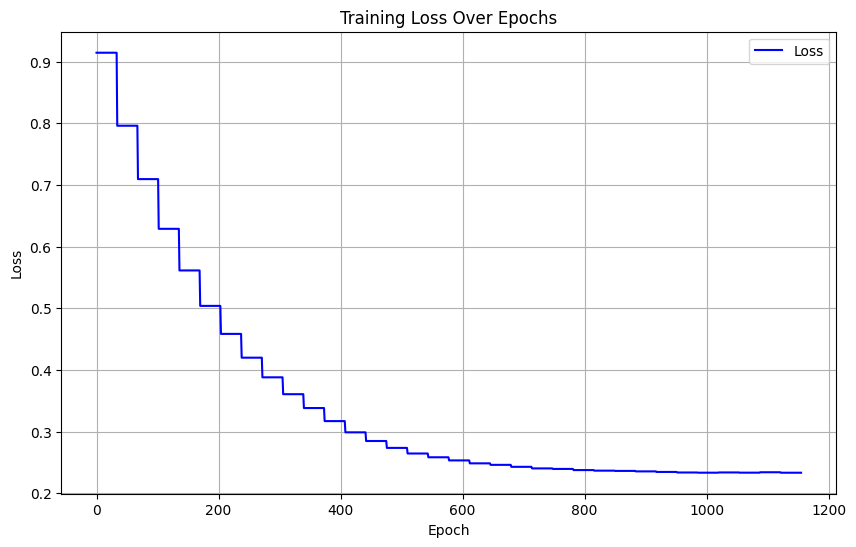

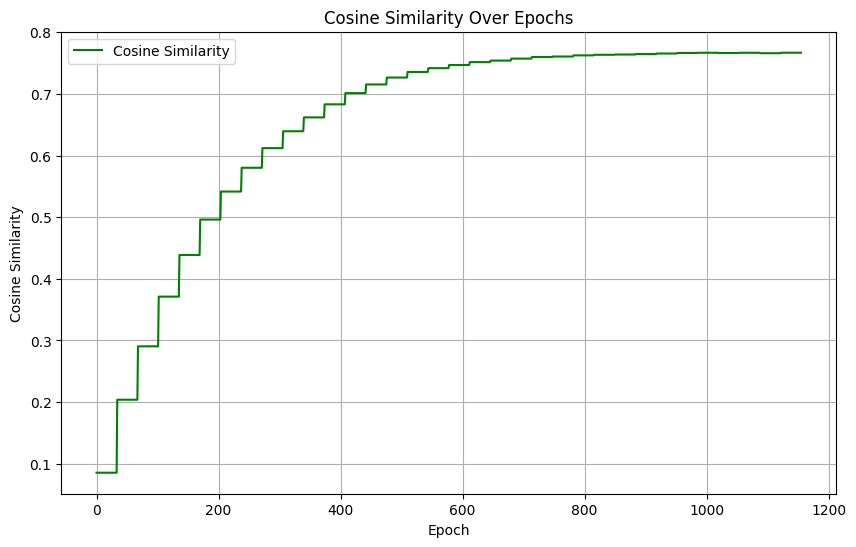

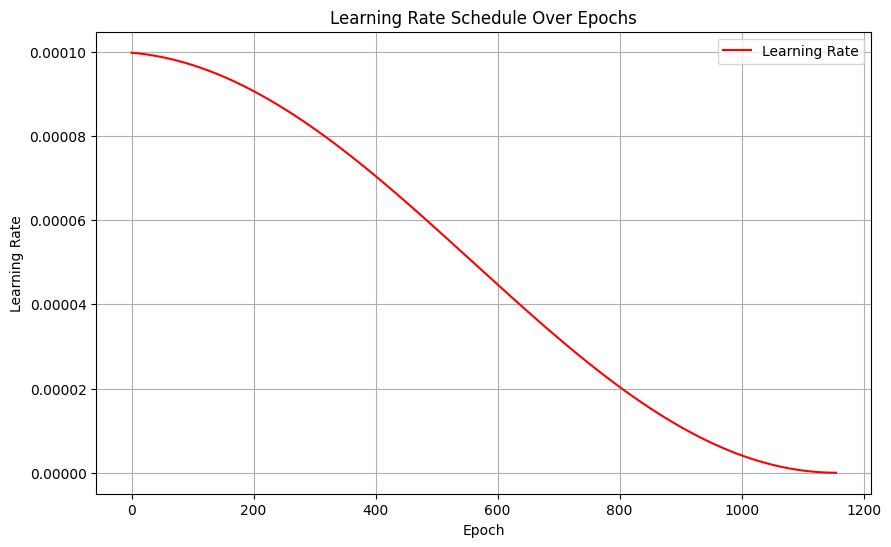

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot similarity
plt.figure(figsize=(10, 6))
plt.plot(history['similarity'], label='Cosine Similarity', color='g')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning rate
plt.figure(figsize=(10, 6))
plt.plot(history['learning_rate'], label='Learning Rate', color='r')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the entire model to Keras format
drive_path = '/content/drive/MyDrive/sign_language_model'  # adjust path as needed
os.makedirs(drive_path, exist_ok=True)

try:
    # Save the full model (architecture + weights + optimizer)
    model_path = os.path.join(drive_path, 'final_model_v1.keras')
    trained_model_v1.save(model_path)
    print(f"Model saved successfully to {model_path}!")

    # Optionally, save weights separately (if desired)
    weights_path = os.path.join(drive_path, 'final_weights_v1.weights.h5')
    trained_model_v1.save_weights(weights_path)
    print("Weights saved successfully!")

except Exception as e:
    print(f"Error saving model: {e}")


Model saved successfully to /content/drive/MyDrive/sign_language_model/final_model_v1.keras!
Weights saved successfully!


In [ ]:
!mkdir /content/drive/MyDrive/SLR_Mod

In [ ]:
!mv /content/sign_language_model /content/drive/MyDrive/SLR_Mod

In [ ]:
import numpy as np

In [ ]:
np.load('/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Landmarks/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute.avi_pid0_fn000000-0_landmarks.npy')

array([[[ 7.38018513e-01,  8.48823786e-01,  9.64776561e-08],
        [ 7.19966054e-01,  8.10895860e-01, -2.48034187e-02],
        [ 6.87213004e-01,  7.79423118e-01, -4.18638438e-02],
        [ 6.56790376e-01,  7.57994115e-01, -5.51449619e-02],
        [ 6.33740783e-01,  7.42136359e-01, -6.84475675e-02],
        [ 6.66364610e-01,  8.31246972e-01, -5.18479124e-02],
        [ 6.25034690e-01,  8.38323534e-01, -7.01189786e-02],
        [ 5.96184969e-01,  8.45218062e-01, -8.04237127e-02],
        [ 5.71025014e-01,  8.53651106e-01, -8.77828673e-02],
        [ 6.65951014e-01,  8.63996148e-01, -4.74529676e-02],
        [ 6.25027120e-01,  8.85396242e-01, -6.57026619e-02],
        [ 5.94088614e-01,  9.01480019e-01, -7.62998462e-02],
        [ 5.66083789e-01,  9.17921603e-01, -8.53794441e-02],
        [ 6.66323602e-01,  8.87210310e-01, -4.24941517e-02],
        [ 6.25882804e-01,  9.09009039e-01, -5.77010401e-02],
        [ 5.95588744e-01,  9.23989415e-01, -6.56479746e-02],
        [ 5.67986488e-01

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

# Paths
image_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Mediapipe_Processed_Test'
landmarks_path = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Landmarks_test'
output_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Merged_Test'
checkpoint_file = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/checkpoints.txt'

# Create output folder if it doesn't exist
os.makedirs(output_folder_base, exist_ok=True)

# Load checkpoint file
processed_folders = set()
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        processed_folders = set(line.strip() for line in f)

# Save completed folder to checkpoint file
def save_checkpoint(folder_id):
    with open(checkpoint_file, 'a') as f:
        f.write(f"{folder_id}\n")

# Create bounding box from landmarks
def create_bounding_box(landmarks, image_shape, padding=0.05):
    x_coords = np.array([lm[0] * image_shape[1] for lm in landmarks])
    y_coords = np.array([lm[1] * image_shape[0] for lm in landmarks])
    x_min = max(0, np.min(x_coords) - padding * image_shape[1])
    x_max = min(image_shape[1], np.max(x_coords) + padding * image_shape[1])
    y_min = max(0, np.min(y_coords) - padding * image_shape[0])
    y_max = min(image_shape[0], np.max(y_coords) + padding * image_shape[0])
    return int(x_min), int(y_min), int(x_max), int(y_max)

# Process a single folder
def process_folder(folder_id):
    # Check if folder is already processed
    if folder_id in processed_folders:
        print(f"Skipping {folder_id}, already processed.")
        return

    folder_path = os.path.join(image_folder_base, folder_id, '1')
    output_folder = os.path.join(output_folder_base, folder_id)
    os.makedirs(output_folder, exist_ok=True)

    if not os.path.exists(folder_path):
        return

    # List images and corresponding landmark files
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.png')])
    landmark_files = [
        os.path.join(landmarks_path, folder_id, '1', f"{os.path.splitext(os.path.basename(img))[0]}_landmarks.npy")
        for img in image_files
    ]

    for image_file, landmark_file in tqdm(zip(image_files, landmark_files), total=len(image_files), desc=f"Processing {folder_id}"):
        # Read the image
        image = cv2.imread(image_file)
        if image is None or not os.path.exists(landmark_file):
            continue

        try:
            landmarks = np.load(landmark_file, allow_pickle=True)
        except Exception as e:
            print(f"Error loading landmarks for {landmark_file}: {e}")
            continue

        # Prepare merged image
        merged_image = np.zeros_like(image)  # Initialize black canvas of same size as input image

        cropped_hands = []
        for hand_landmarks in landmarks:
            if hand_landmarks is None or len(hand_landmarks) == 0:
                continue

            x_min, y_min, x_max, y_max = create_bounding_box(hand_landmarks, image.shape)
            if x_max <= x_min or y_max <= y_min:
                continue

            cropped_hand = image[y_min:y_max, x_min:x_max]
            cropped_hands.append(cropped_hand)

        # Merge cropped hand images into a single frame
        x_offset = 0
        for hand_idx, cropped_hand in enumerate(cropped_hands):
            hand_width = cropped_hand.shape[1]
            hand_height = cropped_hand.shape[0]

            # Resize cropped_hand to match the height of merged_image
            if merged_image.shape[0] != hand_height:
                cropped_hand = cv2.resize(cropped_hand, (hand_width, merged_image.shape[0]))

            # Ensure merged_image has enough width to accommodate the new hand
            if merged_image.shape[1] < x_offset + hand_width:
                new_width = x_offset + hand_width
                merged_image = cv2.resize(merged_image, (new_width, merged_image.shape[0]))

            # Add the cropped hand to merged_image
            merged_image[:, x_offset:x_offset + hand_width, :] = cropped_hand
            x_offset += hand_width

        # Save the merged image
        merged_image_file = os.path.join(output_folder, os.path.basename(image_file))
        cv2.imwrite(merged_image_file, merged_image)

    # Mark folder as processed
    save_checkpoint(folder_id)

# Process all folders in the annotations dataframe
for folder_id in tqdm(annotation_df_test['id'], desc="Processing All Folders"):
    process_folder(folder_id)

print("All processing completed successfully!")


Processing All Folders:   0%|          | 0/180 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   0%|          | 0/148 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   4%|▍         | 6/148 [00:00<00:02, 47.51it/s]
Processing 01December_2011_Thursday_heute_default-6:   8%|▊         | 12/148 [00:00<00:02, 51.18it/s]
Processing 01December_2011_Thursday_heute_default-6:  12%|█▏        | 18/148 [00:00<00:02, 44.91it/s]
Processing 01December_2011_Thursday_heute_default-6:  16%|█▌        | 23/148 [00:01<00:11, 10.56it/s]
Processing 01December_2011_Thursday_heute_default-6:  18%|█▊        | 26/148 [00:02<00:15,  7.68it/s]
Processing 01December_2011_Thursday_heute_default-6:  20%|█▉        | 29/148 [00:03<00:19,  6.01it/s]
Processing 01December_2011_Thursday_heute_default-6:  21%|██        | 31/148 [00:03<00:21,  5.36it/s]
Processing 01December_2011_Thursday_heute_default-6:  22%|██▏       | 33/148 [00:04<00:23,  4.98it/s]
Processing 01December_2011_T

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

# Paths
image_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Mediapipe_Processed_Test'
landmarks_path = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Landmarks_test'
output_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test'

# Create output folder if it doesn't exist
os.makedirs(output_folder_base, exist_ok=True)

# Create bounding box from landmarks
def create_bounding_box(landmarks, image_shape, padding=0.05):
    x_coords = np.array([lm[0] * image_shape[1] for lm in landmarks])
    y_coords = np.array([lm[1] * image_shape[0] for lm in landmarks])
    x_min = max(0, np.min(x_coords) - padding * image_shape[1])
    x_max = min(image_shape[1], np.max(x_coords) + padding * image_shape[1])
    y_min = max(0, np.min(y_coords) - padding * image_shape[0])
    y_max = min(image_shape[0], np.max(y_coords) + padding * image_shape[0])
    return int(x_min), int(y_min), int(x_max), int(y_max)

# Process a single folder
def process_folder(folder_id):
    folder_path = os.path.join(image_folder_base, folder_id, '1')
    output_folder = os.path.join(output_folder_base, folder_id)
    os.makedirs(output_folder, exist_ok=True)

    if not os.path.exists(folder_path):
        return

    # List images and corresponding landmark files
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.png')])
    landmark_files = [
        os.path.join(landmarks_path, folder_id, '1', f"{os.path.splitext(os.path.basename(img))[0]}_landmarks.npy")
        for img in image_files
    ]

    for image_file, landmark_file in tqdm(zip(image_files, landmark_files), total=len(image_files), desc=f"Processing {folder_id}"):
        # Read the image
        image = cv2.imread(image_file)
        if image is None or not os.path.exists(landmark_file):
            continue

        try:
            landmarks = np.load(landmark_file, allow_pickle=True)
        except Exception as e:
            print(f"Error loading landmarks for {landmark_file}: {e}")
            continue

        # Process left and right hands separately
        for hand_idx, hand_landmarks in enumerate(landmarks):
            if hand_landmarks is None or len(hand_landmarks) == 0:
                continue

            x_min, y_min, x_max, y_max = create_bounding_box(hand_landmarks, image.shape)
            if x_max <= x_min or y_max <= y_min:
                continue

            # Crop the hand image
            cropped_hand = image[y_min:y_max, x_min:x_max]

            # Save the cropped hand with a label indicating left or right
            hand_label = "left" if hand_idx == 0 else "right"
            cropped_hand_file = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_file))[0]}_{hand_label}.png")
            cv2.imwrite(cropped_hand_file, cropped_hand)

# Process all folders in the annotations dataframe
for folder_id in tqdm(annotation_df_test['id'], desc="Processing All Folders"):
    process_folder(folder_id)

print("All processing completed successfully!")


Processing All Folders:   0%|          | 0/180 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   0%|          | 0/148 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   1%|          | 1/148 [00:01<04:42,  1.92s/it]
Processing 01December_2011_Thursday_heute_default-6:   1%|▏         | 2/148 [00:03<04:21,  1.79s/it]
Processing 01December_2011_Thursday_heute_default-6:   3%|▎         | 4/148 [00:04<01:53,  1.27it/s]
Processing 01December_2011_Thursday_heute_default-6:   3%|▎         | 5/148 [00:04<01:41,  1.41it/s]
Processing 01December_2011_Thursday_heute_default-6:   4%|▍         | 6/148 [00:04<01:25,  1.65it/s]
Processing 01December_2011_Thursday_heute_default-6:   5%|▍         | 7/148 [00:05<01:15,  1.86it/s]
Processing 01December_2011_Thursday_heute_default-6:   5%|▌         | 8/148 [00:05<01:08,  2.03it/s]
Processing 01December_2011_Thursday_heute_default-6:   6%|▌         | 9/148 [00:06<01:03,  2.18it/s]
Processing 01December_2011_Thursday

In [1]:
import os
import cv2
from tqdm import tqdm

# Paths
cropped_test_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test'
output_merge_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test_Merge'

# Create output folder if it doesn't exist
os.makedirs(output_merge_folder, exist_ok=True)

def merge_left_right(folder_path, output_folder):
    # Ensure the output subfolder exists
    os.makedirs(output_folder, exist_ok=True)

    # List all files in the folder
    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    base_ids = set([f.rsplit('_', 1)[0] for f in files])  # Extract unique base IDs

    for base_id in tqdm(base_ids, desc=f"Merging in {os.path.basename(folder_path)}"):
        left_file = os.path.join(folder_path, f"{base_id}_left.png")
        right_file = os.path.join(folder_path, f"{base_id}_right.png")

        if not os.path.exists(left_file) or not os.path.exists(right_file):
            # Skip if either left or right hand image is missing
            continue

        # Read left and right images
        left_image = cv2.imread(left_file)
        right_image = cv2.imread(right_file)

        # Ensure both images are valid
        if left_image is None or right_image is None:
            continue

        # Resize images to the same height
        if left_image.shape[0] != right_image.shape[0]:
            height = max(left_image.shape[0], right_image.shape[0])
            left_image = cv2.resize(left_image, (int(left_image.shape[1] * (height / left_image.shape[0])), height))
            right_image = cv2.resize(right_image, (int(right_image.shape[1] * (height / right_image.shape[0])), height))

        # Concatenate images horizontally
        merged_image = cv2.hconcat([left_image, right_image])

        # Save the merged image
        merged_file = os.path.join(output_folder, f"{base_id}.png")
        cv2.imwrite(merged_file, merged_image)

# Process each folder in Cropped_Test
for folder in tqdm(os.listdir(cropped_test_folder), desc="Processing Folders"):
    source_folder = os.path.join(cropped_test_folder, folder)
    if os.path.isdir(source_folder):
        target_folder = os.path.join(output_merge_folder, folder)
        merge_left_right(source_folder, target_folder)

print("All merging completed successfully!")


Processing Folders:   0%|          | 0/23 [00:00<?, ?it/s]
Merging in 01December_2011_Thursday_heute_default-6:   0%|          | 0/138 [00:00<?, ?it/s]
Merging in 01December_2011_Thursday_heute_default-6:   1%|          | 1/138 [00:01<03:37,  1.59s/it]
Merging in 01December_2011_Thursday_heute_default-6:   4%|▎         | 5/138 [00:03<01:15,  1.75it/s]
Merging in 01December_2011_Thursday_heute_default-6:   6%|▌         | 8/138 [00:04<01:10,  1.84it/s]
Merging in 01December_2011_Thursday_heute_default-6:  12%|█▏        | 17/138 [00:04<00:22,  5.36it/s]
Merging in 01December_2011_Thursday_heute_default-6:  17%|█▋        | 23/138 [00:04<00:13,  8.28it/s]
Merging in 01December_2011_Thursday_heute_default-6:  21%|██        | 29/138 [00:05<00:09, 11.86it/s]
Merging in 01December_2011_Thursday_heute_default-6:  27%|██▋       | 37/138 [00:05<00:05, 17.58it/s]
Merging in 01December_2011_Thursday_heute_default-6:  36%|███▌      | 50/138 [00:05<00:02, 29.73it/s]
Merging in 01December_2011_Thursday

All merging completed successfully!


In [2]:
import os
import shutil
from tqdm import tqdm

# Paths
source_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test'
dest_folder_base = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test_Merge'

# Ensure destination folder exists
os.makedirs(dest_folder_base, exist_ok=True)

# Function to copy eligible files to the merge folder
def copy_and_rename_files(source_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

    # List all files in the source folder
    files = os.listdir(source_folder)
    base_names = set(os.path.splitext(file)[0].rsplit('_', 1)[0] for file in files)  # Base names without left/right labels

    for base_name in tqdm(base_names, desc=f"Processing {os.path.basename(source_folder)}"):
        # Check for potential left and right counterparts
        left_file = f"{base_name}_left.png"
        right_file = f"{base_name}_right.png"
        unlabelled_file = f"{base_name}.png"

        left_exists = left_file in files
        right_exists = right_file in files
        unlabelled_exists = unlabelled_file in files

        # Handle cases
        if unlabelled_exists:
            # Copy unlabelled file as-is
            src_path = os.path.join(source_folder, unlabelled_file)
            dest_path = os.path.join(dest_folder, unlabelled_file)
            shutil.copy2(src_path, dest_path)

        elif left_exists and not right_exists:
            # Copy and rename left-only file
            src_path = os.path.join(source_folder, left_file)
            dest_path = os.path.join(dest_folder, f"{base_name}.png")
            shutil.copy2(src_path, dest_path)

        elif right_exists and not left_exists:
            # Copy and rename right-only file
            src_path = os.path.join(source_folder, right_file)
            dest_path = os.path.join(dest_folder, f"{base_name}.png")
            shutil.copy2(src_path, dest_path)

# Iterate through subfolders
for folder in tqdm(os.listdir(source_folder_base), desc="Processing Folders"):
    source_subfolder = os.path.join(source_folder_base, folder)
    dest_subfolder = os.path.join(dest_folder_base, folder)

    if os.path.isdir(source_subfolder):
        copy_and_rename_files(source_subfolder, dest_subfolder)

print("Copying and renaming completed successfully!")


Processing Folders:   0%|          | 0/23 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   0%|          | 0/138 [00:00<?, ?it/s]
Processing 01December_2011_Thursday_heute_default-6:   3%|▎         | 4/138 [00:00<00:06, 21.22it/s]
Processing 01December_2011_Thursday_heute_default-6:   5%|▌         | 7/138 [00:01<00:23,  5.61it/s]
Processing 01December_2011_Thursday_heute_default-6:  23%|██▎       | 32/138 [00:01<00:03, 35.20it/s]
Processing 01December_2011_Thursday_heute_default-6:  33%|███▎      | 46/138 [00:01<00:01, 48.89it/s]
Processing 01December_2011_Thursday_heute_default-6:  42%|████▏     | 58/138 [00:01<00:01, 56.49it/s]
Processing 01December_2011_Thursday_heute_default-6:  51%|█████     | 70/138 [00:01<00:01, 65.74it/s]
Processing 01December_2011_Thursday_heute_default-6:  62%|██████▏   | 86/138 [00:01<00:00, 84.11it/s]
Processing 01December_2011_Thursday_heute_default-6:  75%|███████▌  | 104/138 [00:01<00:00, 96.63it/s]
Processing 01December_2011_Thursd

Copying and renaming completed successfully!


In [10]:
# Adjust paths for merged dataset
sequences_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Cropped_Test_Merge'
vectorized_annotations_folder = '/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations_Test'

# Instantiate OptimizedDataLoader for merged test dataset
dataloader = OptimizedDataLoader(
    annotations_df=annotation_df_test,  # Ensure annotations_df is relevant for the test dataset
    sequences_folder=sequences_folder,
    vectorized_annotations_folder=vectorized_annotations_folder,
    frame_size=(32, 32),  # Resize dimensions
    max_sequence_length=12,  # Maximum frames to process per sequence
    batch_size=4,  # Number of samples per batch
    cache_path='/content/drive/MyDrive/sign_language_cache_merged_test'  # Separate cache path
)

# Create the dataset for merged test
dataset = dataloader.create_dataset()

# Iterate through the dataset
for batch_sequences, batch_annotations in dataset:
    print("Batch sequences shape:", batch_sequences.shape)
    print("Batch annotations shape:", batch_annotations.shape)


Preprocessing sequences...
Preprocessing complete!
Batch sequences shape: (4, 12, 32, 32)
Batch annotations shape: (4, 512)
Batch sequences shape: (4, 12, 32, 32)
Batch annotations shape: (4, 512)
Batch sequences shape: (4, 12, 32, 32)
Batch annotations shape: (4, 512)
Batch sequences shape: (4, 12, 32, 32)
Batch annotations shape: (4, 512)
Batch sequences shape: (4, 12, 32, 32)
Batch annotations shape: (4, 512)


In [6]:
from tqdm import tqdm
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
import numpy as np


# Load a multilingual SBERT model that includes German
model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

# Create the directory for saving embeddings if it doesn't exist
output_dir = "/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations_Test"
os.makedirs(output_dir, exist_ok=True)

# Vectorize annotations and save embeddings with progress bar
for index, row in tqdm(annotation_df_test.iterrows(), total=annotation_df_test.shape[0], desc="Embedding Annotations"):
    annotation_id = row['id']
    annotation_text = row['annotation']

    # Compute embedding for the annotation
    embedding = model.encode(annotation_text)

    # Define the output file path
    output_file = os.path.join(output_dir, f"{annotation_id}.npy")

    # Save the embedding as a .npy file
    with open(output_file, "wb") as f:
        np.save(f, embedding)

print("All embeddings have been saved.")


Embedding Annotations: 100%|██████████| 180/180 [00:08<00:00, 20.32it/s]

All embeddings have been saved.


In [15]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Define cosine similarity loss function if it was used during training
def cosine_similarity_loss(y_true, y_pred):
    return 1 - cosine_similarity(y_true, y_pred)

# Load the trained model with custom loss function
model_path = "/content/drive/MyDrive/SLR_Mod/sign_language_model/final_model.keras"
model = tf.keras.models.load_model(model_path, custom_objects={"cosine_similarity_loss": cosine_similarity_loss})

# Define paths
vectorized_annotations_folder = "/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations_Test"

# Define cosine similarity function
def compute_cosine_similarity(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

# Prepare test dataloader (from your OptimizedDataLoader)
test_dataset = dataloader.create_dataset()

# Initialize results
cosine_similarities = []
ids = annotation_df_test["id"].tolist()
pred_embeds=[]
# Iterate through the dataset and compute predictions
for idx, (sequence_batch, _) in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Processing Test Sequences"):
    # Predict embeddings
    predicted_embeddings = model(sequence_batch, training=False)  # Shape: (batch_size, embedding_dim)

    # For each prediction in the batch
    for i, pred_embedding in enumerate(predicted_embeddings.numpy()):
        # Get corresponding annotation ID
        annotation_id = ids[idx * dataloader.batch_size + i]
        pred_embeds.append((i,pred_embedding))
        # Load the vectorized annotation
        annotation_path = os.path.join(vectorized_annotations_folder, f"{annotation_id}.npy")
        if not os.path.exists(annotation_path):
            print(f"Annotation for ID {annotation_id} not found.")
            continue

        true_annotation_embedding = np.load(annotation_path)

        # Compute cosine similarity
        cos_sim = compute_cosine_similarity(pred_embedding, true_annotation_embedding)
        cosine_similarities.append((annotation_id, cos_sim))

# Display or save results
results_path = "/content/drive/MyDrive/cosine_similarities_test.csv"
results_df = pd.DataFrame(cosine_similarities, columns=["ID", "Cosine Similarity"])
results_df.to_csv(results_path, index=False)

print(f"Cosine similarities saved to {results_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Preprocessing sequences...
Preprocessing complete!


Processing Test Sequences: 100%|██████████| 5/5 [00:00<00:00, 22.99it/s]

Cosine similarities saved to /content/drive/MyDrive/cosine_similarities_test.csv


In [17]:
# Initialize results
cosine_similarities = []
ids = annotation_df_test["id"].tolist()
pred_embeds = []

# Iterate through the dataset and compute predictions
for idx, (sequence_batch, _) in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Processing Test Sequences"):
    # Predict embeddings
    predicted_embeddings = model(sequence_batch, training=False)  # Shape: (batch_size, embedding_dim)

    # For each prediction in the batch
    for i, pred_embedding in enumerate(predicted_embeddings.numpy()):
        # Get corresponding annotation ID
        annotation_id = ids[idx * dataloader.batch_size + i]

        # Append the predicted embedding to the list
        pred_embeds.append(pred_embedding)

# Now pred_embeds contains only the embeddings (list of numpy arrays)
predicted_embeddings = pred_embeds  # This is the list of embeddings you want to use in the next step


Processing Test Sequences: 100%|██████████| 5/5 [00:00<00:00, 32.76it/s]


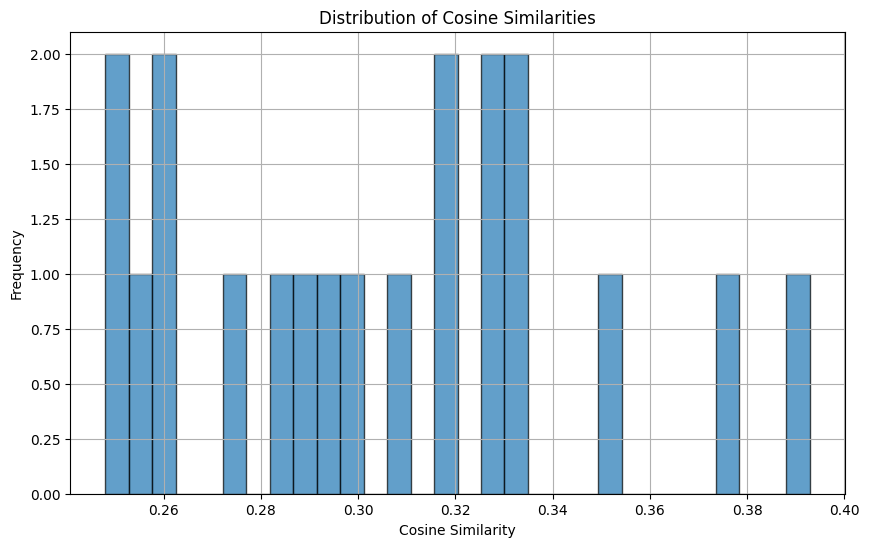

In [13]:
import matplotlib.pyplot as plt

# Generate a histogram of cosine similarities
def plot_cosine_similarities(cosine_similarities):
    similarities = [sim for _, sim in cosine_similarities]

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=30, edgecolor='black', alpha=0.7)
    plt.title("Distribution of Cosine Similarities")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot the results
plot_cosine_similarities(cosine_similarities)


In [14]:
results_df

,ID,Cosine Similarity
0,01December_2011_Thursday_heute_default-6,0.331932
1,01December_2011_Thursday_tagesschau_default-6,0.333930
2,01May_2010_Saturday_tagesschau_default-10,0.248012
3,01May_2010_Saturday_tagesschau_default-11,0.326163
4,01November_2010_Monday_heute_default-8,0.249319
5,01November_2010_Monday_tagesschau_default-2,0.352378
6,01November_2010_Monday_tagesschau_default-6,0.275580
7,01September_2010_Wednesday_tagesschau_default-4,0.261145
8,02August_2010_Monday_heute_default-5,0.295293
9,02December_2009_Wednesday_tagesschau_default-0,0.376763


In [20]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import os
from tqdm import tqdm

class EmbeddingConverter:
    def __init__(self, annotation_df, embeddings_dir, model_name="sentence-transformers/distiluse-base-multilingual-cased-v2"):
        """
        Initialize the converter with annotation dataframe and embeddings directory

        Parameters:
        annotation_df: pandas DataFrame containing 'id' and 'annotation' columns
        embeddings_dir: directory containing the .npy embedding files
        model_name: name of the sentence transformer model to use
        """
        self.annotation_df = annotation_df
        self.embeddings_dir = embeddings_dir
        self.model = SentenceTransformer(model_name)

        # Create a dictionary mapping IDs to annotations
        self.id_to_annotation = dict(zip(annotation_df['id'], annotation_df['annotation']))

        # Load all embeddings into memory for faster similarity search
        self.id_to_embedding = {}
        self.load_embeddings()

        # Create reverse lookup: embedding array to ID
        self.embeddings_matrix = np.stack(list(self.id_to_embedding.values()))
        self.ids_list = list(self.id_to_embedding.keys())

    def load_embeddings(self):
        """Load all embeddings from the directory into memory"""
        print("Loading embeddings into memory...")
        for id_ in tqdm(self.annotation_df['id']):
            embedding_path = os.path.join(self.embeddings_dir, f"{id_}.npy")
            if os.path.exists(embedding_path):
                self.id_to_embedding[id_] = np.load(embedding_path)

    def find_nearest_sentence(self, predicted_embedding, n=1):
        """
        Find the n closest matching sentences for a predicted embedding

        Parameters:
        predicted_embedding: numpy array of the predicted embedding
        n: number of closest matches to return

        Returns:
        List of tuples (sentence, similarity_score, id)
        """
        # Reshape predicted embedding if necessary
        if len(predicted_embedding.shape) == 1:
            predicted_embedding = predicted_embedding.reshape(1, -1)

        # Calculate cosine similarity with all stored embeddings
        similarities = cosine_similarity(predicted_embedding, self.embeddings_matrix)[0]

        # Get indices of top n similar embeddings
        top_indices = np.argsort(similarities)[-n:][::-1]

        # Create list of results
        results = []
        for idx in top_indices:
            id_ = self.ids_list[idx]
            sentence = self.id_to_annotation[id_]
            similarity = similarities[idx]
            results.append((sentence, similarity, id_))

        return results

    def batch_convert_predictions(self, predicted_embeddings, n=1):
        """
        Convert a batch of predicted embeddings to their nearest sentences

        Parameters:
        predicted_embeddings: numpy array of shape (batch_size, embedding_dim)
        n: number of closest matches to return per prediction

        Returns:
        List of lists containing (sentence, similarity_score, id) tuples
        """
        results = []
        for embedding in tqdm(predicted_embeddings, desc="Converting predictions"):
            matches = self.find_nearest_sentence(embedding, n=n)
            results.append(matches)
        return results

    def encode_new_sentence(self, sentence):
        """
        Encode a new sentence using the same model

        Parameters:
        sentence: string to encode

        Returns:
        numpy array of the embedding
        """
        return self.model.encode(sentence)

# Example usage
def create_converter_and_demonstrate():
    # Assuming annotation_df_test and output_dir are defined as in your code
    converter = EmbeddingConverter(
        annotation_df=annotation_df_test,
        embeddings_dir="/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations_Test"
    )


    predicted_embedding = np.random.rand(512)  # Adjust size based on your actual embedding dimension
    matches = converter.find_nearest_sentence(predicted_embedding, n=3)
    print("\nTop 3 matches for single prediction:")
    for sentence, score, id_ in matches:
        print(f"ID: {id_}")
        print(f"Sentence: {sentence}")
        print(f"Similarity Score: {score:.4f}")
        print()


# Function to convert model predictions to sentences
def convert_predictions_to_sentences(predictions, converter):
    """
    Convert model predictions (embeddings) to German sentences

    Parameters:
    predictions: numpy array of shape (n_predictions, embedding_dim)
    converter: initialized EmbeddingConverter instance

    Returns:
    List of dictionaries containing matched sentences and their scores
    """
    results = converter.batch_convert_predictions(predictions, n=3)

    converted_results = []
    for prediction_matches in results:
        prediction_result = {
            'best_match': prediction_matches[0][0],
            'best_match_score': float(prediction_matches[0][1]),
            'best_match_id': prediction_matches[0][2],
            'alternative_matches': [
                {
                    'sentence': match[0],
                    'score': float(match[1]),
                    'id': match[2]
                }
                for match in prediction_matches[1:]
            ]
        }
        converted_results.append(prediction_result)

    return converted_results

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [22]:
# First initialize the converter with your test annotation dataframe
converter = EmbeddingConverter(
    annotation_df=annotations_df,
    embeddings_dir="/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations"
)

# Assuming your predicted embeddings are stored in a variable called predicted_embeddings
# Convert the predictions to sentences
results = convert_predictions_to_sentences(predicted_embeddings, converter)

# Print predictions with their matches in a readable format
print("Predictions to German Sentences Conversion Results:")
print("-" * 80)

for i, result in enumerate(results, 1):
    print(f"\nPrediction {i}:")
    print(f"Best matching sentence: {result['best_match']}")
    print(f"Confidence score: {result['best_match_score']:.4f}")
    print(f"Sentence ID: {result['best_match_id']}")

    if result['alternative_matches']:
        print("\nAlternative matches:")
        for alt in result['alternative_matches']:
            print(f"- {alt['sentence']}")
            print(f"  Score: {alt['score']:.4f}")
            print(f"  ID: {alt['id']}")
    print("-" * 80)

# If you want to save the results to a CSV file
results_df = pd.DataFrame([
    {
        'prediction_number': i+1,
        'best_match_sentence': r['best_match'],
        'confidence_score': r['best_match_score'],
        'sentence_id': r['best_match_id'],
        'alternative_1': r['alternative_matches'][0]['sentence'] if r['alternative_matches'] else '',
        'alternative_1_score': r['alternative_matches'][0]['score'] if r['alternative_matches'] else 0,
        'alternative_2': r['alternative_matches'][1]['sentence'] if len(r['alternative_matches']) > 1 else '',
        'alternative_2_score': r['alternative_matches'][1]['score'] if len(r['alternative_matches']) > 1 else 0
    }
    for i, r in enumerate(results)
])

# Save to CSV
results_df.to_csv('prediction_results.csv', index=False)
print("\nResults have been saved to 'prediction_results.csv'")

Loading embeddings into memory...


Converting predictions: 100%|██████████| 20/20 [00:00<00:00, 117.47it/s]


Predictions to German Sentences Conversion Results:
--------------------------------------------------------------------------------

Prediction 1:
Best matching sentence: SUEDRAUM FREUNDLICH MEHR TROCKEN SONNTAG WIND VERSCHWINDEN __EMOTION__ BLEIBEN __PU__ __OFF__
Confidence score: 0.4234
Sentence ID: 02February_2011_Wednesday_tagesschau_default-13

Alternative matches:
- MORGEN BAYERN KALT __EMOTION__ EIN BIS DREI GRAD SONST REGION VIER BIS SIEBEN GRAD STEIGEN __OFF__
  Score: 0.4218
  ID: 05December_2011_Monday_heute_default-9
- MORGEN DREIZEHN GRAD NORDWESTRAUM DREI ZWEI SIEBEN ZWANZIG REGION SEE __OFF__
  Score: 0.4206
  ID: 23May_2011_Monday_tagesschau_default-11
--------------------------------------------------------------------------------

Prediction 2:
Best matching sentence: MORGEN DREIZEHN GRAD NORDWESTRAUM DREI ZWEI SIEBEN ZWANZIG REGION SEE __OFF__
Confidence score: 0.4232
Sentence ID: 23May_2011_Monday_tagesschau_default-11

Alternative matches:
- MORGEN NORDRAUM ZWEI B

In [23]:
import os
import numpy as np

# Define the paths for training and test embeddings
vectorized_train_annotations_folder = "/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations"  # Replace with your training embeddings folder
vectorized_test_annotations_folder = "/content/drive/MyDrive/Sign Language Detection Anshuman Rath/Vector_annotations_Test"  # Replace with your test embeddings folder

# Function to load embeddings from a folder
def load_embeddings_from_folder(folder_path):
    embeddings_dict = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".npy"):
            annotation_id = os.path.splitext(file_name)[0]  # Extract annotation ID from file name
            file_path = os.path.join(folder_path, file_name)
            embeddings_dict[annotation_id] = np.load(file_path)
    return embeddings_dict

# Load training embeddings
train_embeddings_dict = load_embeddings_from_folder(vectorized_train_annotations_folder)

# Load test embeddings
test_embeddings_dict = load_embeddings_from_folder(vectorized_test_annotations_folder)

# Combine training and test embeddings
all_embeddings_dict = {**train_embeddings_dict, **test_embeddings_dict}

# Verify the size of the combined dictionary
print(f"Total embeddings loaded: {len(all_embeddings_dict)}")


Total embeddings loaded: 4556


In [24]:
import os
import numpy as np

# Function to load embeddings using annotations as keys
def load_embeddings_with_annotations(folder_path, annotation_df):
    embeddings_dict = {}
    for idx, row in annotation_df.iterrows():
        annotation_text = row['annotation']  # German annotation as the key
        annotation_id = row['id']  # Corresponding ID
        file_path = os.path.join(folder_path, f"{annotation_id}.npy")

        if os.path.exists(file_path):
            embeddings_dict[annotation_text] = np.load(file_path)
        else:
            print(f"Embedding not found for ID {annotation_id} (Annotation: {annotation_text})")
    return embeddings_dict

# Load training embeddings with annotations as keys
train_embeddings_dict = load_embeddings_with_annotations(vectorized_train_annotations_folder, train_annotation_df)

# Load test embeddings with annotations as keys
test_embeddings_dict = load_embeddings_with_annotations(vectorized_test_annotations_folder, test_annotation_df)

# Combine training and test embeddings
all_embeddings_dict = {**train_embeddings_dict, **test_embeddings_dict}

# Verify the size of the combined dictionary
print(f"Total annotations loaded: {len(all_embeddings_dict)}")


Total annotations loaded: 4533


In [25]:
import pickle

# Save the dictionary to a file
output_path = "/content/drive/MyDrive/all_embeddings_dict.pkl"  # Change path as needed
with open(output_path, "wb") as f:
    pickle.dump(all_embeddings_dict, f)

print(f"Dictionary saved to {output_path}")


Dictionary saved to /content/drive/MyDrive/all_embeddings_dict.pkl


In [26]:
!python -c "import tensorflow as tf; print(tf.__version__)"


2024-11-24 23:24:43.453704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 23:24:43.474257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 23:24:43.480467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 23:24:44.836935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.17.1
